# Homework 4 Solutions

In [1]:
import jax
import jax.numpy as jnp
from jax import config

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()


## Problem 1

In [2]:
def FTCS_solver_grad(u0, nu, dx, dt, N, T):
    # Initialize the solution array
    u = u0.copy()[:-1]

    # Define the number of time steps (alter dt slightly so that we hit the exact time T)
    num_steps = int(T / dt)
    dt = T / num_steps

    # Main time-stepping loop
    for n in range(num_steps):
        # Compute the spatial derivative (centered in space)
        uxx = (jnp.roll(u, 1) - 2 * u + jnp.roll(u, -1)) / (dx**2)

        # Update the solution using forward time-stepping
        u += nu * dt * uxx

    return jnp.append(u, u[0])


u_measured = jnp.load("u_measured.npy")

nu0 = 0.7
N = len(u_measured) - 1
L = 2.0
T = 0.12
dx = L / N

# Choose a time step that satisfies the stability condition for the initial nu value
mu0 = 0.4
dt = mu0 * dx**2 / nu0
print(f"{dt=}")
x = jnp.linspace(0, L, N+1)
u_init = 1 - jnp.abs(x - 1)

# Loss function performs time marching and then computes the sum of the squared error
# between the computed solution and the measured solution
def loss(nu):
    u = FTCS_solver_grad(u_init, nu, dx, dt, N, T)
    return jnp.sum((u - u_measured)[:-1] ** 2) # ignore the last point since it is periodic


def gradient_descent(f, grad_f, x0, step_size=0.1, max_iter=500, tol=1e-6):
    x = x0
    converged = False
    loss_history = []
    x_history = []
    for ii in range(max_iter):
        func_val = f(x)
        dfdx = grad_f(x)
        print(f"Iteration {ii:03d}: x = {x: 11.7e}, f(x) = {func_val: 11.7e}, dfdx = {dfdx: 11.7e}")
        loss_history.append(func_val)
        x_history.append(x)
        if jnp.linalg.norm(dfdx) < tol:
            converged = True
            break
        x = x - step_size * dfdx
    if converged:
        print(f"Converged after {ii} iterations")
    else:
        print(f"Did not converge after {max_iter} iterations")

    history = {"x": x_history, "loss": loss_history}
    return x, func_val, history


print(f"Loss at nu = 0.7: {loss(nu0)}")
nu_true, loss, history = gradient_descent(loss, jax.grad(loss), nu0, max_iter=50, tol=1e-6)
print(f"Final nu = {nu_true: 11.7e}, loss = {loss: 11.7e}")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


dt=0.007142857142857144
Loss at nu = 0.7: 0.1744257691770037
Iteration 000: x =  7.0000000e-01, f(x) =  1.7442577e-01, dfdx =  9.7625577e-01
Iteration 001: x =  6.0237442e-01, f(x) =  1.1683553e-01, dfdx =  5.2065987e-01
Iteration 002: x =  5.5030844e-01, f(x) =  9.0600870e-02, dfdx =  4.8537114e-01
Iteration 003: x =  5.0177132e-01, f(x) =  6.8037952e-02, dfdx =  4.4267154e-01
Iteration 004: x =  4.5750417e-01, f(x) =  4.9475539e-02, dfdx =  3.9440550e-01
Iteration 005: x =  4.1806362e-01, f(x) =  3.4906500e-02, dfdx =  3.4298133e-01
Iteration 006: x =  3.8376548e-01, f(x) =  2.4012455e-02, dfdx =  2.9111009e-01
Iteration 007: x =  3.5465448e-01, f(x) =  1.6248636e-02, dfdx =  2.4137141e-01
Iteration 008: x =  3.3051733e-01, f(x) =  1.0964106e-02, dfdx =  1.9582898e-01
Iteration 009: x =  3.1093444e-01, f(x) =  7.5164023e-03, dfdx =  1.5581134e-01
Iteration 010: x =  2.9535330e-01, f(x) =  5.3504992e-03, dfdx =  1.2188819e-01
Iteration 011: x =  2.8316448e-01, f(x) =  4.0335698e-03, d

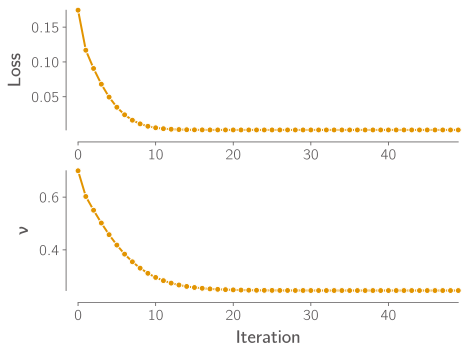

In [3]:

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(history["loss"], "o-", clip_on=False)
axes[0].set_ylabel("Loss")
axes[1].plot(history["x"], "o-", clip_on=False)
axes[1].set_ylabel(r"$\nu$")
axes[1].set_xlabel("Iteration")
niceplots.adjust_spines(axes[0])
niceplots.adjust_spines(axes[1])


Text(0, 0.5, '$u$')

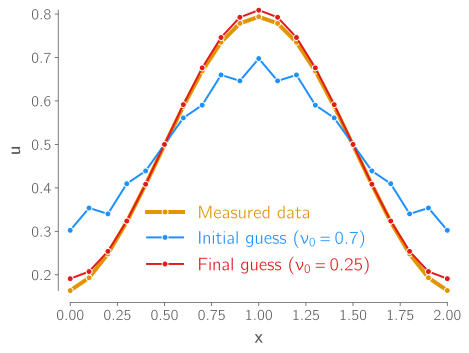

In [4]:
fig, ax = plt.subplots()
u_init_guess = FTCS_solver_grad(u_init, nu0, dx, dt, N, T)
u_soln = FTCS_solver_grad(u_init, nu_true, dx, dt, N, T)
ax.plot(x, u_measured, "-o", clip_on=False, label="Measured data", linewidth=4)
ax.plot(x, u_init_guess, "-o", clip_on=False, label=f"Initial guess ($\\nu_0 = {nu0}$)")
ax.plot(x, u_soln, "-o", clip_on=False, label=f"Final guess ($\\nu_0 = {nu_true:.02f}$)")
ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")


## Problem 2



Running FE at Pe = 10
Using CFL condition, max dt = 1.562e-02
Using heat number condition, max dt = 1.221e-03
Used dt = 1.220e-03 for Pe = 10


Running RK4 at Pe = 10
Using CFL condition, max dt = 1.562e-02
Using heat number condition, max dt = 1.221e-03
Used dt = 1.701e-03 for Pe = 10


Running FE at Pe = 100
Using CFL condition, max dt = 1.562e-02
Using heat number condition, max dt = 1.221e-02
Used dt = 1.250e-02 for Pe = 100


Running RK4 at Pe = 100
Using CFL condition, max dt = 1.562e-02
Using heat number condition, max dt = 1.221e-02
Used dt = 1.724e-02 for Pe = 100


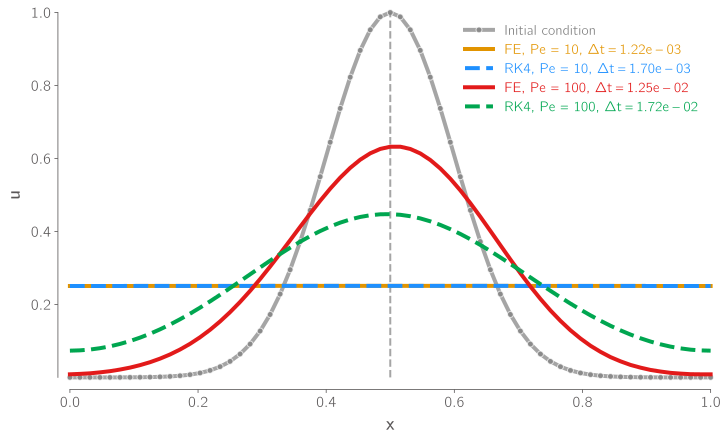

In [5]:
import numpy as np
import scipy.sparse as sparse


def buildAdvecDiffMat(N, a, nu, dx):
    rows = []
    cols = []
    data = []
    advecWeight = a / (2 * dx)
    diffWeight = nu / dx**2
    leftWeight = advecWeight + diffWeight
    rightWeight = -advecWeight + diffWeight
    for ii in range(N):
        left = (ii - 1) % N
        right = (ii + 1) % N
        rows += [ii, ii, ii]
        cols += [left, ii, right]
        data += [leftWeight, -2 * diffWeight, rightWeight]

    return sparse.csr_matrix((data, (rows, cols)))


def f(u, A):
    """Computes du/dt for the 1D advection diffusion equation using central finite differences

    Parameters
    ----------
    u : ndarray
        current state
    A : matrix
        dudt matrix
    """
    return A @ u


def solvePeriodicIVP(u0, dt, T, dudtFunc, stepFunc):
    # Initialize the solution array (ignore right end node due to periodicity)
    u = u0.copy()[:-1]

    # Define the number of time steps (alter dt slightly so that we hit the exact time T)
    num_steps = int(T / dt)
    dt = T / num_steps

    for _ in range(num_steps):
        stepFunc(u, dt, dudtFunc)

    return np.append(u, u[0]), dt


def forwardEulerStep(u, dt, dudtFunc):
    u += dt * dudtFunc(u)
    return


def RK4Step(u, dt, dudtFunc):
    f0 = dudtFunc(u)
    f1 = dudtFunc(u + dt / 2 * f0)
    f2 = dudtFunc(u + dt / 2 * f1)
    f3 = dudtFunc(u + dt * f2)
    u += dt / 6 * (f0 + 2 * f1 + 2 * f2 + f3)
    return


N = 64
L = 1
dx = L / N
x = np.linspace(0, L, N + 1)
u0 = np.exp(-50 * (x / L - 0.5) ** 2)

pecletNums = [10, 100]
a = 1
T = 2 * L / a

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")

ax.plot(x, u0, "-o", color="gray", alpha=0.7, clip_on=False, label="Initial condition", linewidth=4)
ax.axvline(L / 2, color="gray", alpha=0.7, linestyle="--")

timeSteppers = {"FE": forwardEulerStep, "RK4": RK4Step}

FETimesteps = [1.22e-3, 1.25e-2]
RK4Timesteps = [1.7e-3, 1.72e-2]
timesteps = [FETimesteps, RK4Timesteps]

for ii, pecletNum in enumerate(pecletNums):
    nu = a * L / pecletNum
    A = buildAdvecDiffMat(N, a, nu, dx)
    for jj, (name, timeStepper) in enumerate(timeSteppers.items()):
        # Estimate a stable timestep using the heat number and CFL conditions
        maxDiffusionTimestep = dx**2 / (2 * nu)
        maxAdvectionTimestep = dx / a
        # dt = 1.0*min(maxDiffusionTimestep, maxAdvectionTimestep)
        dt = timesteps[jj][ii]

        print("\n")
        print(f"Running {name} at Pe = {pecletNum}")
        print(f"Using CFL condition, max dt = {maxAdvectionTimestep:.3e}")
        print(f"Using heat number condition, max dt = {maxDiffusionTimestep:.3e}")

        dudtFunc = lambda u: f(u, A)
        u, dt = solvePeriodicIVP(u0, dt, T, dudtFunc, timeStepper)
        print(f"Used dt = {dt:.3e} for Pe = {pecletNum}")

        if name == "FE":
            lineStyle = "-"
        else:
            lineStyle = "--"
        ax.plot(
            x, u, f"{lineStyle}", clip_on=False, linewidth=4, label=f"{name}, Pe = {pecletNum}, $\Delta t = {dt:4.2e}$"
        )

ax.legend(labelcolor="linecolor", fontsize=14)
niceplots.adjust_spines(ax)


The P\'eclet number represents the ratio of advection and diffusion.
In this problem, you are asked to simulate up to $T = 2L/a$, which is the time it takes for the initial wave to move exactly 2 domain lengths.
The higher the P\'eclet number, the more advection dominates over diffusion, and the less the initial wave will have diffused by this time.
Because of this we see that the solution for $Pe=100$ is much closer to the initial condition than the solution for $Pe=10$, which is almost completely flattened out.

The FE and RK4 schemes appear to give identical solutions for the $Pe=10$ case, but for the $Pe=100$ case, they give significantly different solutions, this is because the stable timestep is much larger in this case and larger timesteps lead to larger errors.
Since RK4 is a higher-order multi-stage scheme, we can predict that the RK4 solution is closer to the true solution than the FE solution.

## Problem 3



Running AM2 at Pe = 10, dt = 2.000e+00
Used dt = 2.000e+00


Running AM2 at Pe = 10, dt = 2.000e-01
Used dt = 2.000e-01


Running AM2 at Pe = 10, dt = 3.125e-02
Used dt = 3.125e-02


Running AM2 at Pe = 100, dt = 2.000e+00
Used dt = 2.000e+00


Running AM2 at Pe = 100, dt = 2.000e-01
Used dt = 2.000e-01


Running AM2 at Pe = 100, dt = 3.125e-02
Used dt = 3.125e-02


/home/ali/packages/miniconda3/envs/AE523/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


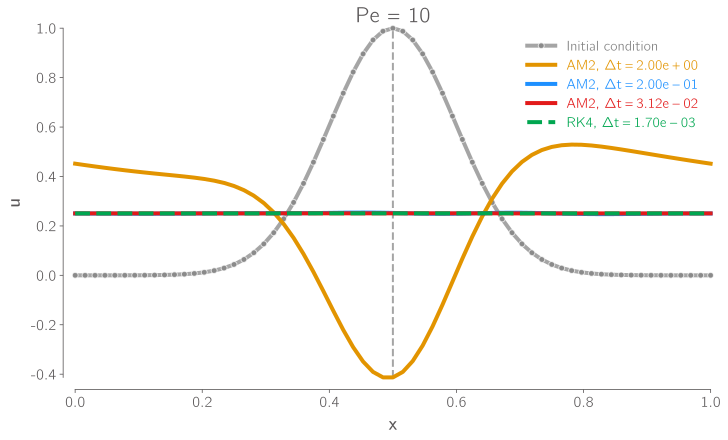

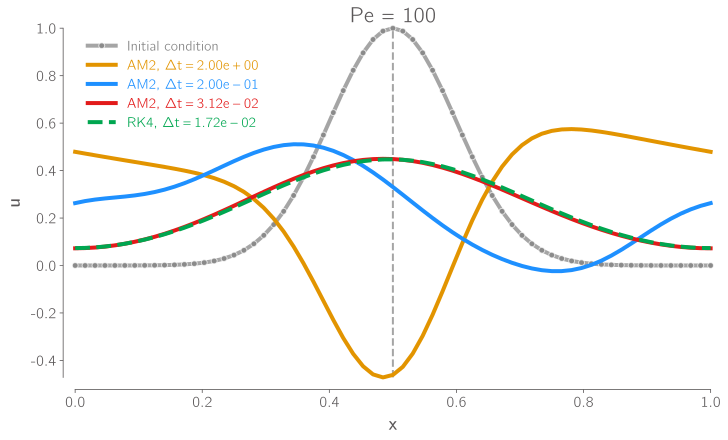

In [6]:
def solvePeriodicIVPAM2(u0, dt, T, A):
    # Initialize the solution array (ignore right end node due to periodicity)
    u = u0.copy()[:-1]

    # Define the number of time steps (alter dt slightly so that we hit the exact time T)
    num_steps = int(T / dt)
    dt = T / num_steps

    mat1 = sparse.eye(A.shape[0]) - dt / 2 * A
    mat2 = sparse.eye(A.shape[0]) + dt / 2 * A
    # This makes a "factorized" version of the matrix (I - dt/2 A) which allows us to solve solve the linear system:
    # (I - dt/2 A) * x = rhs
    # for u for many different rhs vectors quickly
    solve = sparse.linalg.factorized(mat1)

    for _ in range(num_steps):
        u = solve(mat2 @ u)

    return np.append(u, u[0]), dt


dts = T / np.array([1, 10, N])
for ii, pecletNum in enumerate(pecletNums):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u$")

    ax.plot(x, u0, "-o", color="gray", alpha=0.7, clip_on=False, label="Initial condition", linewidth=4)
    ax.axvline(L / 2, color="gray", alpha=0.7, linestyle="--")

    nu = a * L / pecletNum
    A = buildAdvecDiffMat(N, a, nu, dx)

    for dt in dts:
        print("\n")
        print(f"Running AM2 at Pe = {pecletNum}, dt = {dt:.3e}")
        u, dt = solvePeriodicIVPAM2(u0, dt, T, A)
        print(f"Used dt = {dt:.3e}")

        ax.plot(x, u, clip_on=False, linewidth=4, label=f"AM2, $\Delta t = {dt:4.2e}$")

    # Compare with the RK4 solution
    u, dt = solvePeriodicIVP(u0, RK4Timesteps[ii], T, dudtFunc, timeStepper)
    ax.plot(x, u, "--", clip_on=False, linewidth=4, label=f"RK4, $\Delta t = {dt:4.2e}$")

    ax.set_title(f"Pe = {pecletNum}")
    ax.legend(labelcolor="linecolor", fontsize=14)
    niceplots.adjust_spines(ax)


To show that AM2 is stable for all timesteps, we show results with $\Delta t$ ranging from $T/N$ up to the largest possible value, $\Delta t = T$.

The AM2 solutions for the 2 largest timestep sizes are clearly highly inaccurate, but they are still stable.
The AM2 solution for $\Delta t = T/N$ is similar to the RK4 solution, there remains a slight difference though since the largest stable timestep for RK4 is lower than $T/N$.